<img src="images/ScDo-Bandeau_Lingua_Technologies.png" style="width: 100%;float:center;"/>

<h1 style="font-size:250%;text-align:center">Évolution temporelle de la</h1>
<h1 style="font-size:250%;text-align:center">pandémie de la COVID-19 (SARS-CoV-2)</h1>
<h4 style="font-size:150%;text-align:center">par Claude COULOMBE</h4>
<h5 style="font-size:100%;text-align:center">PhD, scientifique de données, consultant Lingua Technologies</h5>


<img src="images/ScDo-pandas_logo.png" width=400 />

Pour contrer l'anxiété de la pandémie de COVID-19, rien de mieux que d'agir. J'ai donc préparé un petit carnet Web Python, prétexte pour un petit exercice d'exploration de données avec Pandas.

### Importation des bibliothèques utilisées

In [1]:
# Importation des bibliothèques
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pylab import *
%matplotlib inline


## Données

### Dépôt de données ouvertes de la COVID-19 - Johns Hopkins University

https://github.com/CSSEGISandData/COVID-19

<img src="" style="width: 100%;float:center;"/>

**Note** : Les données contenues dans le répertoire DATA doivent être mise à jour régulièrement pour refléter l'évolution de la pandémie dans le temps. 


### Lecture des données

Nous nous intéressons au fichier `time_series_covid19_confirmed_global.csv` qui contient les données sur les cas confirmés de COVID-19

In [2]:
# Note - bonne pratique de postfixer les Dataframe par _df (Rappel: Python n'est pas typé)
series_chronologiques_COVID19_df = pd.read_csv('DATA/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv',sep=',')


## Exploration des données

In [3]:
series_chronologiques_COVID19_df.head()


,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,4/28/20,4/29/20,4/30/20,5/1/20,5/2/20,5/3/20,5/4/20,5/5/20,5/6/20,5/7/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,1828,1939,2171,2335,2469,2704,2894,3224,3392,3563
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,750,766,773,782,789,795,803,820,832,842
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,3649,3848,4006,4154,4295,4474,4648,4838,4997,5182
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,...,743,743,745,745,747,748,750,751,751,752
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,...,27,27,27,30,35,35,35,36,36,36


In [4]:
series_chronologiques_COVID19_df.tail()


,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,4/28/20,4/29/20,4/30/20,5/1/20,5/2/20,5/3/20,5/4/20,5/5/20,5/6/20,5/7/20
261,NaN,Western Sahara,24.215500,-12.885800,0,0,0,0,0,0,...,6,6,6,6,6,6,6,6,6,6
262,NaN,Sao Tome and Principe,0.186360,6.613081,0,0,0,0,0,0,...,8,8,14,16,16,16,23,174,174,187
263,NaN,Yemen,15.552727,48.516388,0,0,0,0,0,0,...,1,6,6,7,10,10,12,22,25,25
264,NaN,Comoros,-11.645500,43.333300,0,0,0,0,0,0,...,0,0,1,1,3,3,3,3,8,8
265,NaN,Tajikistan,38.861034,71.276093,0,0,0,0,0,0,...,0,0,15,15,76,128,230,293,379,461


### Afficher les propriétés globales du tableau de données / DataFrame

Sa forme, les structures de données sous-jacentes et une description statistiques des variables numériques

In [5]:
series_chronologiques_COVID19_df.shape


(266, 111)

In [6]:
series_chronologiques_COVID19_df.columns


Index(['Province/State', 'Country/Region', 'Lat', 'Long', '1/22/20', '1/23/20',
       '1/24/20', '1/25/20', '1/26/20', '1/27/20',
       ...
       '4/28/20', '4/29/20', '4/30/20', '5/1/20', '5/2/20', '5/3/20', '5/4/20',
       '5/5/20', '5/6/20', '5/7/20'],
      dtype='object', length=111)

In [7]:
nbr_jours = len(series_chronologiques_COVID19_df.columns) - 4
nbr_jours


107

In [8]:
series_chronologiques_COVID19_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 266 entries, 0 to 265
Columns: 111 entries, Province/State to 5/7/20
dtypes: float64(2), int64(107), object(2)
memory usage: 230.8+ KB


In [9]:
series_chronologiques_COVID19_df.describe()


,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,...,4/28/20,4/29/20,4/30/20,5/1/20,5/2/20,5/3/20,5/4/20,5/5/20,5/6/20,5/7/20
count,266.000000,266.000000,266.000000,266.000000,266.000000,266.000000,266.000000,266.000000,266.000000,266.000000,...,2.660000e+02,2.660000e+02,2.660000e+02,2.660000e+02,2.660000e+02,2.660000e+02,2.660000e+02,2.660000e+02,2.660000e+02,2.660000e+02
mean,21.259359,22.432499,2.086466,2.458647,3.537594,5.390977,7.962406,11.003759,20.969925,23.180451,...,1.164372e+04,1.192589e+04,1.224402e+04,1.257059e+04,1.288565e+04,1.318319e+04,1.347013e+04,1.376952e+04,1.411782e+04,1.445759e+04
std,24.747943,70.478908,27.279200,27.377862,34.083035,47.434934,66.289178,89.313757,219.187744,220.524977,...,6.750720e+04,6.918850e+04,7.102976e+04,7.311436e+04,7.495782e+04,7.657327e+04,7.801568e+04,7.957189e+04,8.121537e+04,8.306894e+04
min,-51.796300,-135.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,6.907750,-18.093125,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,7.500000e+01,7.600000e+01,7.725000e+01,8.100000e+01,8.200000e+01,8.225000e+01,8.675000e+01,9.350000e+01,9.525000e+01,9.650000e+01
50%,23.488100,20.921188,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,4.335000e+02,4.555000e+02,4.665000e+02,4.855000e+02,4.995000e+02,5.085000e+02,5.425000e+02,5.480000e+02,5.560000e+02,5.625000e+02
75%,41.143200,77.191525,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.020000e+03,2.047250e+03,2.105250e+03,2.165750e+03,2.359250e+03,2.515000e+03,2.635750e+03,2.699750e+03,2.872750e+03,2.939500e+03
max,71.706900,178.065000,444.000000,444.000000,549.000000,761.000000,1058.000000,1423.000000,3554.000000,3554.000000,...,1.012582e+06,1.039909e+06,1.069424e+06,1.103461e+06,1.132539e+06,1.158040e+06,1.180375e+06,1.204351e+06,1.228603e+06,1.257023e+06


### Examen de la distribution des données et des attributs

In [10]:
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
from pandas.api.types import is_string_dtype, is_numeric_dtype 

NBR_MAX_ATTRIBUTS_AFFICHES = 53

# Pour chaque attribut ou colonne d'un tableau de données / DataFrame
# Créer une boîte à moustaches, un histogramme ou une liste de valeurs possibles

def examen_distributions_attributs(un_dataframe):
    for attribut in un_dataframe.columns:
        # Afficher le type d'attribut
        print("-"*90)
        print("Attribut:",attribut,", Type:",un_dataframe.dtypes[attribut])
        # Si c'est un attribut catégoriel alors lister toutes les valeurs possibles
        if is_string_dtype(un_dataframe[attribut]):
            attributs_uniques = list(un_dataframe[attribut].unique())
            print("Nombre d'attributs_uniques:",len(attributs_uniques))
            if len(attributs_uniques) > NBR_MAX_ATTRIBUTS_AFFICHES:
                print("Affichage des " + str(NBR_MAX_ATTRIBUTS_AFFICHES) + " premières valeurs:")
                print(attributs_uniques[:NBR_MAX_ATTRIBUTS_AFFICHES])
            else:
                print(attributs_uniques)
                print("\nun_dataframe.groupby('"+attribut+"').size()\n",un_dataframe.groupby(attribut).size())
        if is_numeric_dtype(un_dataframe[attribut]):
            _ = un_dataframe.boxplot(attribut, figsize=(2, 3))
            plt.show()
            print()
            plt.close()
            _ = un_dataframe[attribut].plot(kind='hist',figsize=(2, 3))
            plt.show()
    print("-"*90)


In [11]:
# examen_distributions_attributs(series_chronologiques_COVID19_df)


### Retrait d'attributs «superflus»

Puisque nous nous intéressons à l'évolution du nombre de malades dans le temps, certains attributs (colonnes du tableau de données) sont superflus ou «inutiles» et alourdissent notre analyse.

Ci-dessous une liste d'attributs à retirer:

In [12]:
attributs_a_retirer = ["Lat","Long"]


Retirer les attributs «superflus» avec la fonction `.drop()`

In [13]:
series_chronologiques_COVID19_df = series_chronologiques_COVID19_df.drop(attributs_a_retirer,axis='columns')


In [14]:
series_chronologiques_COVID19_df.head()


,Province/State,Country/Region,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,...,4/28/20,4/29/20,4/30/20,5/1/20,5/2/20,5/3/20,5/4/20,5/5/20,5/6/20,5/7/20
0,NaN,Afghanistan,0,0,0,0,0,0,0,0,...,1828,1939,2171,2335,2469,2704,2894,3224,3392,3563
1,NaN,Albania,0,0,0,0,0,0,0,0,...,750,766,773,782,789,795,803,820,832,842
2,NaN,Algeria,0,0,0,0,0,0,0,0,...,3649,3848,4006,4154,4295,4474,4648,4838,4997,5182
3,NaN,Andorra,0,0,0,0,0,0,0,0,...,743,743,745,745,747,748,750,751,751,752
4,NaN,Angola,0,0,0,0,0,0,0,0,...,27,27,27,30,35,35,35,36,36,36


### Modification du format des dates

Pour l'affichage de date selon la norme des pays francophones.

In [15]:
new_columns = ['Province/State','Country/Region']
for date_raw in series_chronologiques_COVID19_df.columns:
    if not date_raw in ['Province/State','Country/Region']:
        split_date = date_raw.split("/")
        new_date = split_date[1]+"/"+split_date[0]+"/"+split_date[2]+"20"
        # print(new_date)
        new_columns.append(new_date)
    
series_chronologiques_COVID19_df.columns = new_columns
series_chronologiques_COVID19_df


,Province/State,Country/Region,22/1/2020,23/1/2020,24/1/2020,25/1/2020,26/1/2020,27/1/2020,28/1/2020,29/1/2020,...,28/4/2020,29/4/2020,30/4/2020,1/5/2020,2/5/2020,3/5/2020,4/5/2020,5/5/2020,6/5/2020,7/5/2020
0,NaN,Afghanistan,0,0,0,0,0,0,0,0,...,1828,1939,2171,2335,2469,2704,2894,3224,3392,3563
1,NaN,Albania,0,0,0,0,0,0,0,0,...,750,766,773,782,789,795,803,820,832,842
2,NaN,Algeria,0,0,0,0,0,0,0,0,...,3649,3848,4006,4154,4295,4474,4648,4838,4997,5182
3,NaN,Andorra,0,0,0,0,0,0,0,0,...,743,743,745,745,747,748,750,751,751,752
4,NaN,Angola,0,0,0,0,0,0,0,0,...,27,27,27,30,35,35,35,36,36,36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261,NaN,Western Sahara,0,0,0,0,0,0,0,0,...,6,6,6,6,6,6,6,6,6,6
262,NaN,Sao Tome and Principe,0,0,0,0,0,0,0,0,...,8,8,14,16,16,16,23,174,174,187
263,NaN,Yemen,0,0,0,0,0,0,0,0,...,1,6,6,7,10,10,12,22,25,25
264,NaN,Comoros,0,0,0,0,0,0,0,0,...,0,0,1,1,3,3,3,3,8,8


### Quels sont le différents pays et / ou états que l'on trouve dans les données?

In [16]:
print(list(series_chronologiques_COVID19_df['Province/State'].unique()))


[nan, 'Australian Capital Territory', 'New South Wales', 'Northern Territory', 'Queensland', 'South Australia', 'Tasmania', 'Victoria', 'Western Australia', 'Alberta', 'British Columbia', 'Grand Princess', 'Manitoba', 'New Brunswick', 'Newfoundland and Labrador', 'Nova Scotia', 'Ontario', 'Prince Edward Island', 'Quebec', 'Saskatchewan', 'Anhui', 'Beijing', 'Chongqing', 'Fujian', 'Gansu', 'Guangdong', 'Guangxi', 'Guizhou', 'Hainan', 'Hebei', 'Heilongjiang', 'Henan', 'Hong Kong', 'Hubei', 'Hunan', 'Inner Mongolia', 'Jiangsu', 'Jiangxi', 'Jilin', 'Liaoning', 'Macau', 'Ningxia', 'Qinghai', 'Shaanxi', 'Shandong', 'Shanghai', 'Shanxi', 'Sichuan', 'Tianjin', 'Tibet', 'Xinjiang', 'Yunnan', 'Zhejiang', 'Faroe Islands', 'Greenland', 'French Guiana', 'French Polynesia', 'Guadeloupe', 'Mayotte', 'New Caledonia', 'Reunion', 'Saint Barthelemy', 'St Martin', 'Martinique', 'Aruba', 'Curacao', 'Sint Maarten', 'Bermuda', 'Cayman Islands', 'Channel Islands', 'Gibraltar', 'Isle of Man', 'Montserrat', 'Di

In [17]:
print(list(series_chronologiques_COVID19_df['Country/Region'].unique()))


['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain', 'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Benin', 'Bhutan', 'Bolivia', 'Bosnia and Herzegovina', 'Brazil', 'Brunei', 'Bulgaria', 'Burkina Faso', 'Cabo Verde', 'Cambodia', 'Cameroon', 'Canada', 'Central African Republic', 'Chad', 'Chile', 'China', 'Colombia', 'Congo (Brazzaville)', 'Congo (Kinshasa)', 'Costa Rica', "Cote d'Ivoire", 'Croatia', 'Diamond Princess', 'Cuba', 'Cyprus', 'Czechia', 'Denmark', 'Djibouti', 'Dominican Republic', 'Ecuador', 'Egypt', 'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia', 'Eswatini', 'Ethiopia', 'Fiji', 'Finland', 'France', 'Gabon', 'Gambia', 'Georgia', 'Germany', 'Ghana', 'Greece', 'Guatemala', 'Guinea', 'Guyana', 'Haiti', 'Holy See', 'Honduras', 'Hungary', 'Iceland', 'India', 'Indonesia', 'Iran', 'Iraq', 'Ireland', 'Israel', 'Italy', 'Jamaica', 'Japan', 'Jordan', 'Kazakhstan'

#### Par exemple, examinons les données pour les différents états et régions des États-Unis.

In [18]:
series_chronologiques_COVID19_df[series_chronologiques_COVID19_df['Country/Region']=="US"]


,Province/State,Country/Region,22/1/2020,23/1/2020,24/1/2020,25/1/2020,26/1/2020,27/1/2020,28/1/2020,29/1/2020,...,28/4/2020,29/4/2020,30/4/2020,1/5/2020,2/5/2020,3/5/2020,4/5/2020,5/5/2020,6/5/2020,7/5/2020
225,NaN,US,1,1,2,2,5,5,5,5,...,1012582,1039909,1069424,1103461,1132539,1158040,1180375,1204351,1228603,1257023


#### Maintenant, examinons les données pour les différentes provinces canadiennes.

In [19]:
series_chronologiques_COVID19_df[series_chronologiques_COVID19_df['Country/Region']=="Canada"]


,Province/State,Country/Region,22/1/2020,23/1/2020,24/1/2020,25/1/2020,26/1/2020,27/1/2020,28/1/2020,29/1/2020,...,28/4/2020,29/4/2020,30/4/2020,1/5/2020,2/5/2020,3/5/2020,4/5/2020,5/5/2020,6/5/2020,7/5/2020
35,Alberta,Canada,0,0,0,0,0,0,0,0,...,4850,5165,5355,5573,5670,5766,5836,5893,5963,6017
36,British Columbia,Canada,0,0,0,0,0,0,1,1,...,2053,2087,2112,2145,2171,2171,2224,2232,2255,2288
37,Grand Princess,Canada,0,0,0,0,0,0,0,0,...,13,13,13,13,13,13,13,13,13,13
38,Manitoba,Canada,0,0,0,0,0,0,0,0,...,273,275,277,281,282,282,283,284,286,283
39,New Brunswick,Canada,0,0,0,0,0,0,0,0,...,118,118,118,118,118,118,118,119,120,120
40,Newfoundland and Labrador,Canada,0,0,0,0,0,0,0,0,...,258,258,258,259,259,259,259,259,259,261
41,Nova Scotia,Canada,0,0,0,0,0,0,0,0,...,915,935,947,959,963,971,985,991,998,1007
42,Ontario,Canada,0,0,0,0,1,1,1,1,...,16500,16978,17395,17880,18321,18574,19097,19468,19910,20388
43,Prince Edward Island,Canada,0,0,0,0,0,0,0,0,...,27,27,27,27,27,27,27,27,27,27
44,Quebec,Canada,0,0,0,0,0,0,0,0,...,25761,26610,27550,28656,29664,31873,32631,33425,34334,35249


### Création d'une entrée supplémentaire spécifique pour le Québec (avec accent aigu) 

In [20]:

quebec_df = series_chronologiques_COVID19_df[(series_chronologiques_COVID19_df['Country/Region']=="Canada") & 
                                (series_chronologiques_COVID19_df['Province/State']=="Quebec")]

quebec_df.loc[44,'Country/Region'] = 'Québec'
quebec_df.loc[44,'Province/State'] = np.nan

series_chronologiques_COVID19_df = series_chronologiques_COVID19_df.append(quebec_df , ignore_index=True)
series_chronologiques_COVID19_df


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,Province/State,Country/Region,22/1/2020,23/1/2020,24/1/2020,25/1/2020,26/1/2020,27/1/2020,28/1/2020,29/1/2020,...,28/4/2020,29/4/2020,30/4/2020,1/5/2020,2/5/2020,3/5/2020,4/5/2020,5/5/2020,6/5/2020,7/5/2020
0,NaN,Afghanistan,0,0,0,0,0,0,0,0,...,1828,1939,2171,2335,2469,2704,2894,3224,3392,3563
1,NaN,Albania,0,0,0,0,0,0,0,0,...,750,766,773,782,789,795,803,820,832,842
2,NaN,Algeria,0,0,0,0,0,0,0,0,...,3649,3848,4006,4154,4295,4474,4648,4838,4997,5182
3,NaN,Andorra,0,0,0,0,0,0,0,0,...,743,743,745,745,747,748,750,751,751,752
4,NaN,Angola,0,0,0,0,0,0,0,0,...,27,27,27,30,35,35,35,36,36,36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
262,NaN,Sao Tome and Principe,0,0,0,0,0,0,0,0,...,8,8,14,16,16,16,23,174,174,187
263,NaN,Yemen,0,0,0,0,0,0,0,0,...,1,6,6,7,10,10,12,22,25,25
264,NaN,Comoros,0,0,0,0,0,0,0,0,...,0,0,1,1,3,3,3,3,8,8
265,NaN,Tajikistan,0,0,0,0,0,0,0,0,...,0,0,15,15,76,128,230,293,379,461


### Regroupement des données des états et provinces
**Note** : Pour avoir un total par pays, nous allons regrouper les états et les provinces d'un même pays. Utilisaton des fonctions `.groupby()` et `.sum()`. Aussi `.reset_index()`

In [21]:
series_chronologiques_COVID19_df = series_chronologiques_COVID19_df.groupby(['Country/Region']).sum().reset_index()


Vérifions que le regroupement est bien effectué, avec les données sur le Canada.

In [22]:
series_chronologiques_COVID19_df[series_chronologiques_COVID19_df['Country/Region']=="Canada"]


,Country/Region,22/1/2020,23/1/2020,24/1/2020,25/1/2020,26/1/2020,27/1/2020,28/1/2020,29/1/2020,30/1/2020,...,28/4/2020,29/4/2020,30/4/2020,1/5/2020,2/5/2020,3/5/2020,4/5/2020,5/5/2020,6/5/2020,7/5/2020
32,Canada,0,0,0,0,1,1,2,2,2,...,51150,52865,54457,56343,57926,60504,61957,63215,64694,66201


In [23]:
series_chronologiques_COVID19_df[series_chronologiques_COVID19_df['Country/Region']=="Québec"]


,Country/Region,22/1/2020,23/1/2020,24/1/2020,25/1/2020,26/1/2020,27/1/2020,28/1/2020,29/1/2020,30/1/2020,...,28/4/2020,29/4/2020,30/4/2020,1/5/2020,2/5/2020,3/5/2020,4/5/2020,5/5/2020,6/5/2020,7/5/2020
138,Québec,0,0,0,0,0,0,0,0,0,...,25761,26610,27550,28656,29664,31873,32631,33425,34334,35249


In [24]:
# Correction d'une erreur dans les données du 4 avril 2020
series_chronologiques_COVID19_df.loc[137,'4/4/2020']=6997
series_chronologiques_COVID19_df[series_chronologiques_COVID19_df['Country/Region']=="Québec"]


,Country/Region,22/1/2020,23/1/2020,24/1/2020,25/1/2020,26/1/2020,27/1/2020,28/1/2020,29/1/2020,30/1/2020,...,28/4/2020,29/4/2020,30/4/2020,1/5/2020,2/5/2020,3/5/2020,4/5/2020,5/5/2020,6/5/2020,7/5/2020
138,Québec,0,0,0,0,0,0,0,0,0,...,25761,26610,27550,28656,29664,31873,32631,33425,34334,35249


## Visualisation des données


### Visualisation de l'évolution du nombre de malades dans le temps

Nous allons visualiser l'évolution du nombre de malades dans le temps au moyen de graphiques et pouvoir comparer entre différents pays dans le monde.

Jetons à nouveau un coup d'oeil à notre tableau de données.

In [25]:
series_chronologiques_COVID19_df


,Country/Region,22/1/2020,23/1/2020,24/1/2020,25/1/2020,26/1/2020,27/1/2020,28/1/2020,29/1/2020,30/1/2020,...,28/4/2020,29/4/2020,30/4/2020,1/5/2020,2/5/2020,3/5/2020,4/5/2020,5/5/2020,6/5/2020,7/5/2020
0,Afghanistan,0,0,0,0,0,0,0,0,0,...,1828,1939,2171,2335,2469,2704,2894,3224,3392,3563
1,Albania,0,0,0,0,0,0,0,0,0,...,750,766,773,782,789,795,803,820,832,842
2,Algeria,0,0,0,0,0,0,0,0,0,...,3649,3848,4006,4154,4295,4474,4648,4838,4997,5182
3,Andorra,0,0,0,0,0,0,0,0,0,...,743,743,745,745,747,748,750,751,751,752
4,Angola,0,0,0,0,0,0,0,0,0,...,27,27,27,30,35,35,35,36,36,36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183,West Bank and Gaza,0,0,0,0,0,0,0,0,0,...,343,344,344,353,353,353,362,371,374,375
184,Western Sahara,0,0,0,0,0,0,0,0,0,...,6,6,6,6,6,6,6,6,6,6
185,Yemen,0,0,0,0,0,0,0,0,0,...,1,6,6,7,10,10,12,22,25,25
186,Zambia,0,0,0,0,0,0,0,0,0,...,95,97,106,109,119,124,137,138,146,153


### Création d'un graphique multicourbes (une courbe par pays)

1. Nous allons créer une visualisation simple des différentes courbes d'évolution au fil des jours du nombre de malades «confirmés» pour différents pays.


2. Pour ne pas surcharger notre graphique, nous allons sélectionner certains pays qui sont plus représentatifs de la situation. 

    2.1 Évidemment le Canada
    
    2.2 Des pays qui ont appliqués des mesures sanitaires strictes, de quarantaine et de distanciation sociale: la Chine, le Japon, la Corée du Sud, et Singapour
    
    2.3 Des pays qui ont soit tardé à imposer des mesures strictes ou dont le système de santé         a manqué de moyens : la France, l'Italie, l'Iran, l'Espagne, et les États-Unis.

Pour faciliter la visualisation dans un graphique plus compact, à cause de la grande disparité du nombre de malades, nous allons utiliser une échelle logarithmique pour le nombre de malades confirmés. 

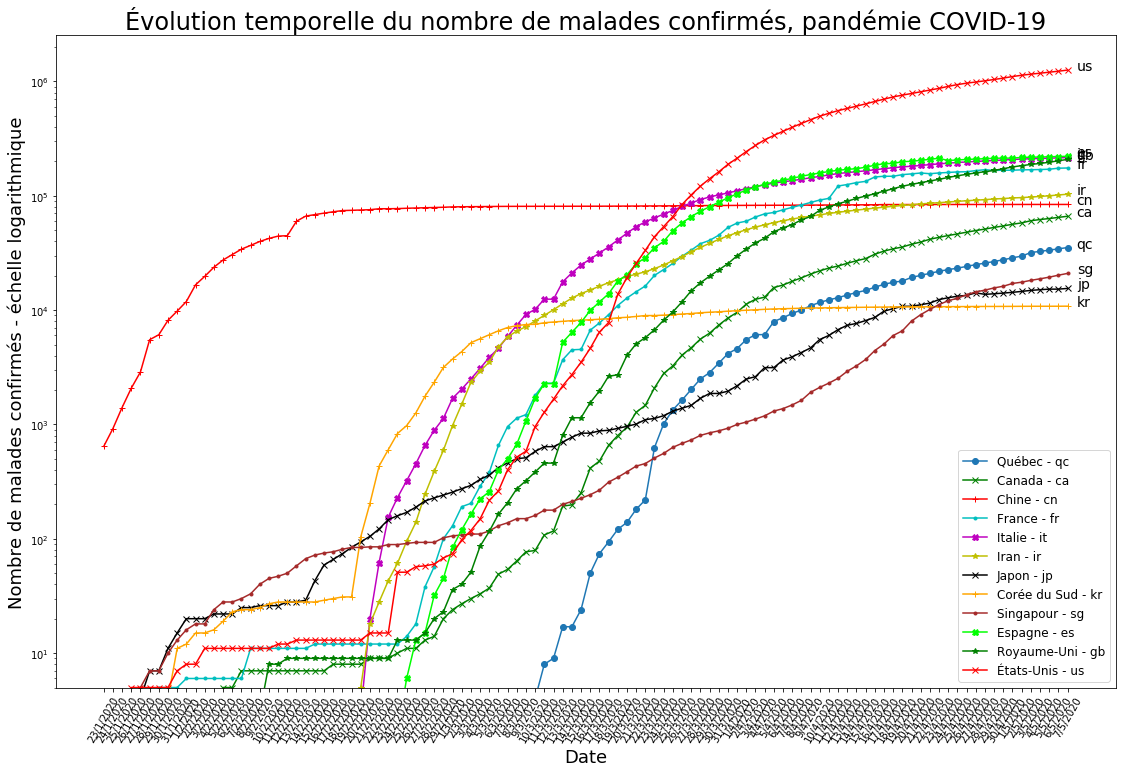

In [26]:
import itertools
from random import randrange

nombre_dor = 1.618
hauteur = 12
longueur = int(nombre_dor * hauteur)
fig, ax = plt.subplots(figsize=(longueur,hauteur))
# https://stackoverflow.com/questions/13091649/unique-plot-marker-for-each-plot-in-matplotlib
marqueurs = itertools.cycle(('x', '+', '.', 'X', '*'))
couleurs = itertools.cycle(('g', 'r', 'c', 'm', 'y', 'k', 'orange', 'brown', 'lime'))

import matplotlib.colors as pltcol

regions = ['Québec', 'Canada', 'China', 'France', 'Italy', 'Iran', 'Japan',
           'Korea, South', 'Singapore', 'Spain', 'United Kingdom', 'US']

etiquettes = {'Québec':'Québec', 'Canada':'Canada', 'China':'Chine', 'France':'France', 
              'Italy':'Italie', 'Iran':'Iran','Japan':'Japon','Korea, South':'Corée du Sud',
              'Singapore':'Singapour','Spain':'Espagne', 'Sweden':'Suède', 
              'United Kingdom':'Royaume-Uni', 'US':'États-Unis'}

code_pays = { 
    'Québec':'qc', 'Canada':'ca', 'China':'cn', 'France':'fr', 
    'Italy':'it', 'Iran':'ir','Japan':'jp',
    'Korea, South':'kr', 'Singapore':'sg', 
    'Spain':'es', 'Sweden':'se','United Kingdom':'gb', 'US':'us'
} 

for region in regions:
    if region == "Québec":
        marqueur = "o"
        couleur = "tab:blue"
    else:
        marqueur = next(marqueurs)
        couleur = next(couleurs)
    plt.plot(list(series_chronologiques_COVID19_df.columns[2:]), 
             list(series_chronologiques_COVID19_df[series_chronologiques_COVID19_df['Country/Region']==region].iloc[0,2:]), 
             marker=marqueur, 
             color=couleur, 
             label=etiquettes[region]+" - "+code_pays[region])
    etiq_y_pos = series_chronologiques_COVID19_df[series_chronologiques_COVID19_df['Country/Region']==region].iloc[0,-1]
    plt.text(nbr_jours-1, etiq_y_pos, code_pays[region],fontsize=14)    
plt.legend(loc='best',fontsize=12)
xticks(rotation=60)
ax.set_yscale('log')
ylim(bottom=5)
#xlim(right=60)

plt.title(u'Évolution temporelle du nombre de malades confirmés, pandémie COVID-19',fontsize=24)
plt.xlabel(u'Date',fontsize=18)
_ = plt.ylabel(u'Nombre de malades confirmés - échelle logarithmique',fontsize=18)
plt.savefig('images/Evolution-COVID19-EchLog.png')
plt.show()


#### Pour mieux apprécier le phénomène d'accroissement exponentiel

Pour mieux «voir» l'accroissement exponentiel, nous retirons la Chine des pays examinés et nous mettons en commentaire la ligne `ax.set_yscale('log')` qui définit l'échelle logarithmique en ordonnée (i.e. axe vertical). Nous revenons donc à une échelle linéaire.

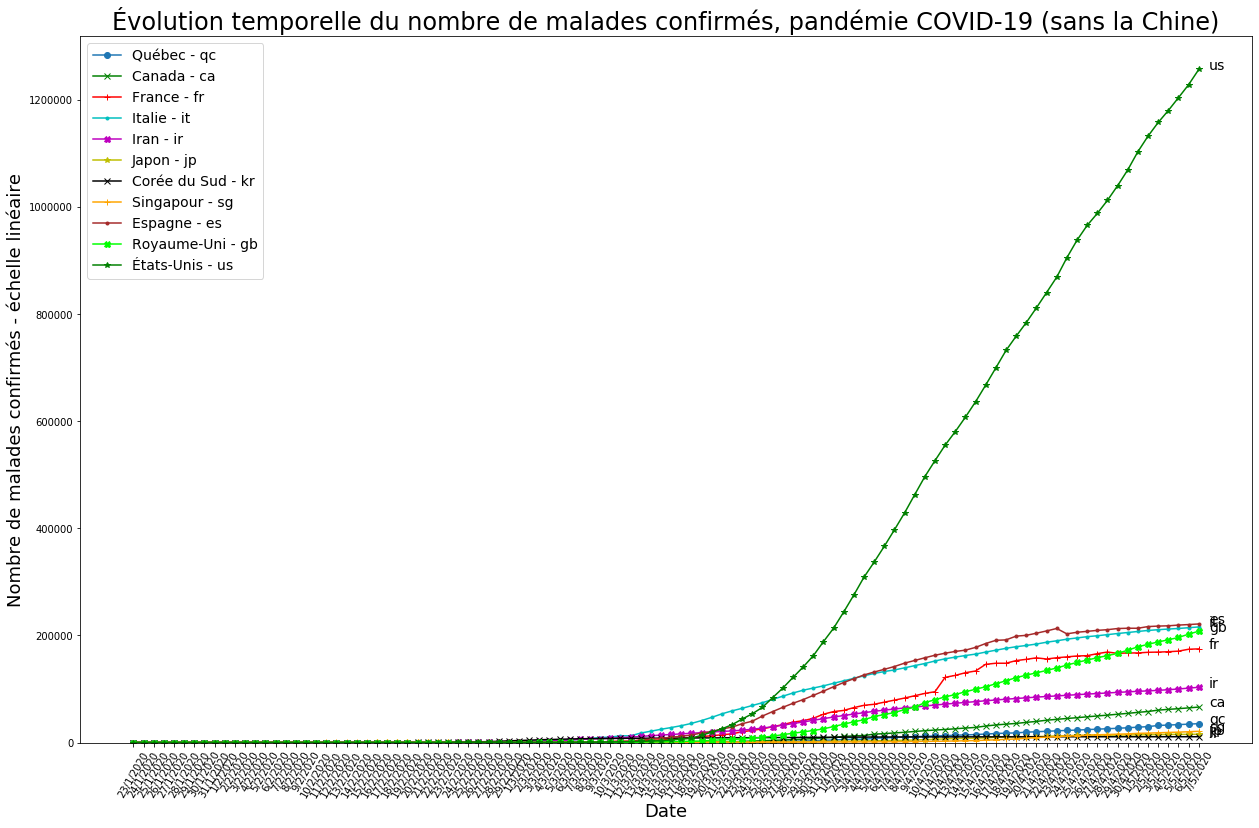

In [27]:
import itertools

nombre_dor = 1.618
hauteur = 13
longueur = int(nombre_dor * hauteur)
fig, ax = plt.subplots(figsize=(longueur,hauteur))
# https://stackoverflow.com/questions/13091649/unique-plot-marker-for-each-plot-in-matplotlib
marqueurs = itertools.cycle(('x', '+', '.', 'X', '*'))
couleurs = itertools.cycle(('g', 'r', 'c', 'm', 'y', 'k', 'orange', 'brown', 'lime'))

import matplotlib.colors as pltcol

regions = ['Québec', 'Canada', 'France', 'Italy', 'Iran', 
           'Japan','Korea, South', 'Singapore', 'Spain', 'United Kingdom', 'US']

etiquettes = {'Québec':'Québec', 'Canada':'Canada', 'China':'Chine', 'France':'France', 
              'Italy':'Italie', 'Iran':'Iran','Japan':'Japon',
              'Korea, South':'Corée du Sud', 'Singapore':'Singapour', 
              'Spain':'Espagne', 'United Kingdom':'Royaume-Uni', 'US':'États-Unis'}

code_pays = { 
    'Québec':'qc', 'Canada':'ca', 'China':'cn', 'France':'fr', 
    'Italy':'it', 'Iran':'ir','Japan':'jp',
    'Korea, South':'kr', 'Singapore':'sg', 
    'Spain':'es', 'Sweden':'se','United Kingdom':'gb', 'US':'us'
} 

for region in regions:
    if region == "Québec":
        marqueur = "o"
        couleur = "tab:blue"
    else:
        marqueur = next(marqueurs)
        couleur = next(couleurs)
    plt.plot(list(series_chronologiques_COVID19_df.columns[2:]), 
             list(series_chronologiques_COVID19_df[series_chronologiques_COVID19_df['Country/Region']==region].iloc[0,2:]), 
             marker=marqueur, 
             color=couleur, 
             label=etiquettes[region]+" - "+code_pays[region])
    etiq_y_pos = series_chronologiques_COVID19_df[series_chronologiques_COVID19_df['Country/Region']==region].iloc[0,-1]
    plt.text(nbr_jours-1, etiq_y_pos, code_pays[region],fontsize=14)    
plt.legend(loc='best',fontsize=14)
xticks(rotation=60)
#ax.set_yscale('log')
ylim(bottom=0)
plt.title(u'Évolution temporelle du nombre de malades confirmés, pandémie COVID-19 (sans la Chine)',fontsize=24)
plt.xlabel(u'Date',fontsize=18)
_ = plt.ylabel(u'Nombre de malades confirmés - échelle linéaire',fontsize=18)
plt.savefig('images/Evolution-COVID19-moins_Chine-EchNormale.png')
plt.show()


## Analyse sommaire

On constate que les pays, comme la Chine, le Japon, Taïwan, la Corée du sud et Singapour, qui ont pris des mesures draconiennes de quarantaine et l'éloignement physique (la mal nommée distanciation sociale), ont réussi à contenir l'accroissement du nombre de cas. 

Au contraire, les pays qui ont tardé à réagir ou manqué de ressources comme l'Italie, l'Iran, les États-Unis, la France ou l'Espagne n'ont pas encore réussi à ralentir l'accroissement du nombre de malades. Pour le moment le Canada et le Québec se situent entre les deux, mais la tendance des derniers jours fait redouter une potentielle explosion du nombre de malades. Le talon d'Achille demeure les hôpitaux de soins de longue durée (CHSLD) et les résidences pour personnes âgées.

Signe encourageant, on constate une inflexion graduelle du taux d'augmentation au Québec, la courbe s'aplatit. Il est important de ne pas relâcher les mesures d'hygiène et d'isolement physique car il existe un risque de rebond. 